In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import xarray as xr

### Code to loop through every filename

In [2]:
beginning = "3B42_Daily."
end = ".7.nc4"

def YearLoop(yb, ye):
    dates = []
    for i in np.arange(yb, ye+1):
        year = i
        for j in np.arange (1, 12+1):
            month = j
            if len(str(month)) < 2:
                month = str(0) + str(month)
            if j==1 or j==3 or j==5 or j==7 or j==8 or j==10 or (j==12 and year != 2019):
                for k in np.arange (1, 31+1):
                    day = k
                    if len(str(day)) < 2:
                        day = str(0) + str(day)
                    dates.append((str(year) + str(month) + str(day)))
            if j==4 or j==6 or j==9 or j==11 or (j == 12 and year == 2019):
                for k in np.arange (1, 30+1):
                    day = k
                    if len(str(day)) < 2:
                        day = str(0) + str(day)
                    dates.append((str(year) + str(month) + str(day)))
            if j == 2 and year%4 == 0:
                for k in range (1, 29+1):
                    day = k
                    if len(str(day)) < 2:
                        day = str(0) + str(day)
                    dates.append((str(year) + str(month) + str(day)))
            if j == 2 and year%4 != 0:
                for k in range (1, 28+1):
                    day = k
                    if len(str(day)) < 2:
                        day = str(0) + str(day)
                    dates.append((str(year) + str(month) + str(day)))
    return dates

middle = YearLoop(1998, 1998)[0]
filename = beginning + middle + end
print(filename)
print(len(YearLoop(1998, 1998)))

3B42_Daily.19980101.7.nc4
365


### Code that keeps track of the top 25 rainfall events for a given cell in a single year. The number of cells and which cell are input values.

In [3]:
def SingleCellCal(year, a, b, n):
    beginning = "TRMM data/3B42_Daily."
    end = ".7.nc4"
    Loop = YearLoop(year, year)
    maximum = np.zeros([n,25])
    NumberOfDays = len(Loop)
    for i in range(len(Loop)):
        middle = Loop[i]
        filename = beginning + middle + end
        ds = xr.load_dataset(filename)
        for j in range(len(a)):
            if maximum[j,0] < ds.precipitation[a[j],b[j]]:
                maximum[j,0] = ds.precipitation[a[j],b[j]]
                
        maximum = np.sort(maximum)
    np.save(str(n)+"maximumcol"+str(year)+"-"+str(a[0]),maximum)

In [4]:
n = 1  # Number of randomly chosen cells
a = np.random.randint(0,1440, n)  # x coördinate of random cell
b = np.random.randint(0,400, n)  # y coördinate of random cell

# Loops through all the years
for i in np.arange(1998, 2019+1):
    SingleCellCal(i, a, b, n)

### Concatenates the top 25 data for overlapping blocks of 5 years, sorts them and then makes a new top 25. The 1ste, 5th and 25th value are saved for all the blocks of 5 years.

In [22]:
# Construction of all the files names required
beginning = "1maximumcol"
end = "-" + str(a[0]) + ".npy"

year5 = []
year1 = []
year02 = []

# Loops through all the first years of the blocks of 5 years
for k in np.arange(17+1):
    year = 1998 + k
    temp =[]
    c = 0
    
    # Loops through every years in the block of 5 years
    for i in np.arange(year, year+4+1):
        c += 1
        middle = i
        name = beginning + str(middle) + end
        if i == year:
            temp = np.load(name)
        else:
            temp = np.hstack((temp, np.load(name)))

    temp = np.sort(temp)
    Top25 = temp[:,-25:]  # Makes a new top 25 for the 5 years block
    np.save("yearTop" + str(a[0]) + str(year), Top25)
    year5 = Top25[:,24]  # All the 1ste values
    year1 = Top25[:,-5]  # All the 5th values
    year02 = Top25[:,0]  # All the 25th values
    np.save("year5max" + str(a[0]) + str(year) ,year5)
    np.save("year1max" + str(a[0]) + str(year) ,year1)
    np.save("year0,2max" + str(a[0]) + str(year) ,year02)

### Plotting the 5, 1 and 0,2 years recurance amounts of precitpitation and calculating and plotting a trend line through them.

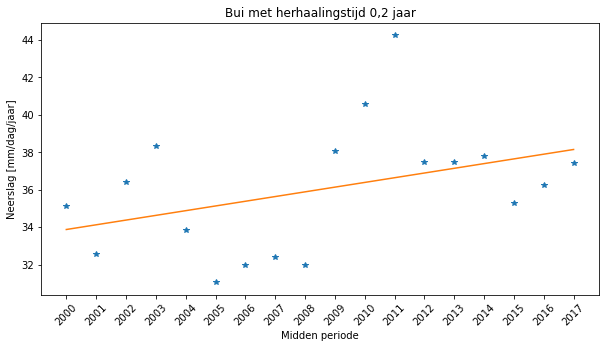

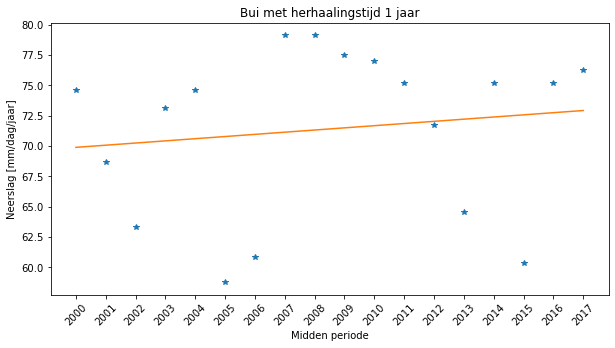

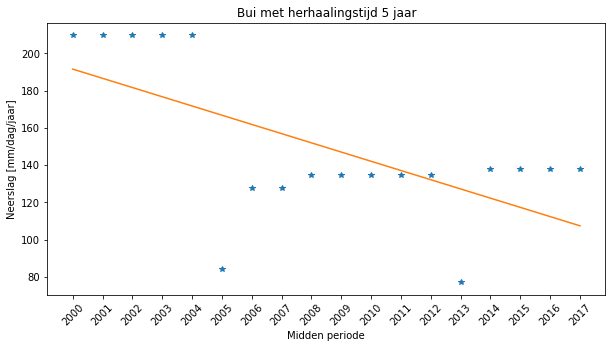

In [25]:
# Function the trend line while be modelled as
def func(x, a, b):
    y = a*x + b
    return y

# Loops through the three recurance periods
for n in np.arange(3):
    plt.figure(figsize=(10,5))
    num = ['0,2', '1', '5']
    alphaArray = []
    y = []
    
    # Loops through every start years of the blocks of 5 years
    for i in np.arange(18):
        name = "year" + str(num[n]) + "max" + str(a[0]) + str(1998 + i) + ".npy"
        data = np.load(name)
        y = np.append(y, data)  
        
    x = np.arange(2000, 2000+18)
    plt.plot(x,y, '*', label=('data punt '+ str(k+1)))
    plt.title('Bui met herhaalingstijd '+ str(num[n])+ ' jaar')
    plt.xlabel('Midden periode')
    plt.ylabel('Neerslag [mm/dag/jaar]')
    alpha = optimize.curve_fit(func, xdata = x, ydata = y)[0]
    plt.plot(x,alpha[0]*x+alpha[1], label='fitlijn')
    plt.xticks(ticks=x, labels = x, rotation=45)
    alphaArray.append(alpha[0])